
## FM modulation: 
$$y_c = sin(2 \pi (f_c + my_m) t_s) $$



In [1]:
import numpy as np
from numpy import sin,pi
import matplotlib.pyplot as plt
#import seaborn as sns


In [2]:
# Variables

sample_period = 1e-4
#sample_period = 1/5000


fc = 100.0

mod_fac = 0.0001

shift = 10.0



In [3]:
# random modulation signal generation
def create_ym0(timeline,shift=None):
    
    if shift is None:
        shift=0.0
    
    num=10
    
    freq = np.random.uniform(low=0.1, high=10.0, size=(1,num))
    amp  = np.random.randint(1,5,size=(1,num))

    series=[]
    for t in timeline:
        timestep=amp.dot(np.transpose(np.sin(freq*2*np.pi*t)))
        series.append(float(timestep))
        
    return np.array(series)+shift

6.288618561386799


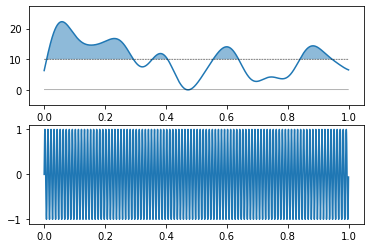

In [4]:
# time series
ts = np.arange(0,1,sample_period)

# modulation signal

#-- Option1
#ym = sin(2*pi*1*ts) + shift

#-- Option2
#%store -r signal1  # created with 'signal_generation.ipynb'
#ym = np.array(signal1) + shift

#--Option3
#ym0=create_ym0(ts,shift)
ym0 = create_ym0(ts)

# shift signal above x-axis
ym = ym0+abs(min(ym0))
print(abs(min(ym0)))

# carrier signal
yc = sin(2 * pi * (fc + mod_fac * ym) * ts )


# __________________________
#
fig = plt.figure(1)

#-------
ax1  = fig.add_subplot(2,1,1)
ax1.plot(ts,ym)
ax1.fill_between(ts,ym,shift*np.ones(len(ts)),where=(ym > shift*np.ones(len(ts))),alpha=0.5)

ax1.plot(ts,shift*np.ones(len(ts)),'k--',linewidth=0.5)
ax1.plot(ts,np.zeros(len(ts)),'k',linewidth=0.3)

ax1.set_ylim(-5,max(ym)+5)

#-------
ax2  = fig.add_subplot(2,1,2)
ax2.plot(ts,yc)

plt.show();

In [5]:
%time

theta_orig = 2 * pi * (fc + mod_fac * ym) * ts 
theta_new  = np.arcsin(yc)


# Calculate the samples per quadrant
N = int(1 / fc / sample_period) 
Nq = int(N / 4)

# Solve the angles for Yc's 1st cycle
quadrant1_theta = theta_new[0:Nq]
quadrant2_theta = pi - theta_new[Nq:Nq*2]
quadrant3_theta = pi - theta_new[Nq*2:Nq*3]
quadrant4_theta = 2.0 * pi + theta_new[Nq*3:Nq*4]
theta_corrected = np.hstack((quadrant1_theta, quadrant2_theta, quadrant3_theta, quadrant4_theta))

number_of_cycles = fc * len(ts) 

# This is our tally
cycle = 1
cycle_start_index = Nq*4
pi_multiple=2

while cycle < number_of_cycles:
    
    # Calculate which sample falls into what quadrant
    quad1_start = cycle_start_index
    quad1_end = quad1_start + Nq
    
    quad23_start = quad1_end
    quad23_end = quad23_start + Nq * 2
    
    quad4_start = quad23_end
    quad4_stop = quad4_start + Nq
    
    # Solve for the angles for Yc's 2nd, 3rd, ... cycles
    quadrant1_theta = theta_new[quad1_start:quad1_end] + pi_multiple * pi 
    quadrant23_theta = pi - theta_new[quad23_start:quad23_end] + pi_multiple * pi
    quadrant4_theta = 2.0 * pi + theta_new[quad4_start:quad4_stop] + pi_multiple * pi 
    
    theta_corrected = np.hstack((theta_corrected, quadrant1_theta, quadrant23_theta, quadrant4_theta))
    
    cycle = cycle + 1
    
    
    # Calculate a distinct offset for each cycle 
    pi_multiple = pi_multiple + 2.0
    
    cycle_start_index = cycle_start_index + N
    
ym_demod = (theta_corrected / (2.0 * pi * ts *  mod_fac) - fc / mod_fac ) - shift


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.34 µs


/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


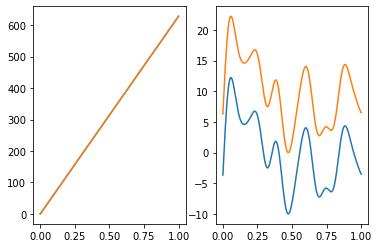

In [6]:
# ___________________________________
#
#fig = plt.figure(4)

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(ts,theta_orig)
ax1.plot(ts,theta_corrected)

ax2.plot(ts,ym_demod)
ax2.plot(ts,ym) # without shift correction 

plt.show();